# Word2Vec Embeddings based on Emotions

In [1]:
import pandas as pd
import math
import random
import numpy as np
import re
import nltk
from nltk import FreqDist
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
# Preprocess the data

#Read the Excel sheet into a pandas DataFrame
df = pd.read_excel('Files/data.xlsx')

# Define the emotions to count
emotions = ['Sadness', 'Joy', 'Fear', 'Anger', 'Surprise', 'Disgust']

# Define the regular expression pattern for tokenization
pattern = r"[^\d\W]+(?:['’][^\d\W]+)?|[^\d\W]+['’]\w*"

# Store Lexicons and Sentences tokenized at each index
emotions_lexicon = {emotion: [] for emotion in emotions}
emotions_sentences = {emotion: [] for emotion in emotions}

# Loop through each emotion
for i, col_name in enumerate(df.columns[1::2]):
    # Extract the emotion name from the column name
    emotion = col_name.replace(' Sentences', '')
    # Get the index of the "Sentences" column for this emotion
    sentences_col_idx = df.columns.get_loc(col_name)
    # Get emotion lexicon from the "Lexicon" column
    lexicon = df.iloc[0:, sentences_col_idx-1].tolist()
    # Get the sentences from the "Sentences" column
    sentences = df.iloc[0:, sentences_col_idx].tolist()
    # Create an empty list to store the lexicon
    lex_tokens = []
    # Create an empty list to store the sentences tokens
    sentences_tokens = []
    # Loop through each lexicon col
    for lexeme in lexicon:
        # Check if the lexicon is a valid string
        if isinstance(lexeme, str):
            # Tokenize the words in each row "lexeme" using regex and Append to array
            lex_tokens.extend(re.findall(pattern, lexeme))
    # Set to lowercase and remove duplicates lexicon
    lex_tokens = list(set(token.lower() for token in lex_tokens))
    # Loop through each sentence col
    for sentence in sentences:
        # Check if the sentence is a valid string
        if isinstance(sentence, str):
          # Tokenize the words in each row "sentence" using regex and Append to array
          sentences_tokens.append(re.findall(pattern, sentence))

    # If the emotion contains more than one emotion, split it and add the words to the respective index arrays
    if '+' in emotion:
        sub_emotions = emotion.split(' + ')
        for sub_emotion in sub_emotions:
            emotions_lexicon[sub_emotion].extend(lex_tokens)
            emotions_sentences[sub_emotion].extend(sentences_tokens)
    else:
        emotions_lexicon[emotion].extend(lex_tokens)
        emotions_sentences[emotion].extend(sentences_tokens)

# Remove duplicates from "Sadness" and "Joy" lexicon
emotions_lexicon['Sadness'] = list(set(emotions_lexicon['Sadness']))
emotions_lexicon['Sadness'].sort()
emotions_lexicon['Joy'] = list(set(emotions_lexicon['Joy']))
emotions_lexicon['Joy'].sort()


# Total sentences
total_sentences = emotions_sentences['Sadness'] + emotions_sentences['Joy']

In [3]:
# All words combined
combined_tokens_original = []
for sentence in emotions_sentences['Sadness']:
    combined_tokens_original.extend(sentence)

for sentence in emotions_sentences['Joy']:
    combined_tokens_original.extend(sentence)

# Convert all words to lowercase
combined_tokens_original = [token.lower() for token in combined_tokens_original]

# Sort all tokens
# Each word index represent unique integer
combined_tokens = sorted(set(combined_tokens_original))
vocabulary_count = len(combined_tokens)


In [4]:
weights = [1, 1, 1, 1, 1]

# Matrix W
matrix = [weights for word in combined_tokens]

# Matrix C
matrix.extend(matrix)

print("vocabulary_count= ", vocabulary_count)

vocabulary_count=  1645


In [5]:
# Get all c_pos for all tokens
c_pos = []

for target_word in combined_tokens:
    target_word_context = []
    for sentence in total_sentences:
        if target_word in sentence:
            index = sentence.index(target_word)
            target_word_context = (sentence[max(index - 4, 0):index] + sentence[index + 1:min(index + 5, len(sentence))])[:4]
            target_word_context_lower = [token.lower() for token in target_word_context]
            #non_neighboring_words = [word for word in sentence if word not in neighboring_words and word != target_word]
            break
    c_pos.append(target_word_context_lower)

# Compute word frequency with weight 0.75
def compute_word_probabilities(words):
    frequency = FreqDist(words)
    total_count = len(words)
    probabilities = {word: pow(freq, 0.75) / pow(total_count, 0.75) for word, freq in frequency.items()}
    return probabilities


# Tokens with p^0.75
combined_tokens_with_p_075 = compute_word_probabilities(combined_tokens_original)

# Function to choose random words for c_neg
def choose_random_tokens(token_array_list, num_tokens, excluded_tokens=[]):
    token_array = list(token_array_list)
    random_tokens = []
    i = num_tokens - 1
    while i >= 0:
      random_word = random.choice(token_array)
      if random_word not in excluded_tokens:
        random_tokens.append(random_word)
        i -= 1
    return random_tokens

# To print and check
result = []
for i, token in enumerate(combined_tokens[:10]):
  exclude_words = [token, c_pos[i]]
  result.append({'token': token, 'c_pos': c_pos[i], 'c_negs': choose_random_tokens(combined_tokens_with_p_075, 5, exclude_words)})

print(result)

[{'token': 'a', 'c_pos': ['the', "child's", 'abduction', 'left'], 'c_negs': ['library', 'couldn’t', 'back', 'chatgpt', 'deceased']}, {'token': 'abandon', 'c_pos': ['she', 'decided', 'to', 'her'], 'c_negs': ['criminal', 'horde', 'hopeless', 'twirl', 'demise']}, {'token': 'abandoned', 'c_pos': ['the', 'child', 'looked', 'up'], 'c_negs': ['mistakes', 'together', 'who', 'favorite', 'position']}, {'token': 'abandonment', 'c_pos': ['the', 'she', 'had', 'went'], 'c_negs': ['contractors', 'mike', 'laughter', 'vampire', 'kitchen']}, {'token': 'abduct', 'c_pos': ['zealous', 'gang', 'lord', 'would'], 'c_negs': ['traumatic', 'fond', 'wished', 'running', 'occasionally']}, {'token': 'abducted', 'c_pos': ['when', 'i', 'see', 'and'], 'c_negs': ['creating', 'revealed', 'responded', 'special', 'smiles']}, {'token': 'abduction', 'c_pos': ['news', 'of', 'the', "child's"], 'c_negs': ['days', 'never', 'he', 'herself', 'excellent']}, {'token': 'abhor', 'c_pos': ['often', 'praises', 'those', 'who'], 'c_negs':

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_loss(w, c_pos, c_negs):
    loss = -1 * np.array((np.log(sigmoid(np.dot(np.array(c_pos), np.array(w)))) + sum(np.log(sigmoid(np.dot((-1) * np.array(c_neg_j), np.array(w)))) for c_neg_j in c_negs)))
    return loss

def c_pos_loss(c_pos, w):
  return (sigmoid(np.dot(np.array(c_pos), np.array(w))) - 1) * np.array(w)

def c_neg_loss(c_neg, w):
  return sigmoid(np.dot(np.array(c_neg), np.array(w))) * np.array(w)

def w_loss(w, c_pos, c_negs):
  return (sigmoid(np.dot(np.array(c_pos), np.array(w))) - 1) * np.array(c_pos) + sum(sigmoid(np.dot(np.array(c_neg), np.array(w))) * np.array(c_neg) for c_neg in c_negs)


In [7]:
def compute_stochastic_gradient_descent(matrix_passed, learning_rate, iterations_num):
    # Total loss
    total_loss = float('inf')
    for i in range(iterations_num):
      for word_index, word in enumerate(matrix_passed[:vocabulary_count]):

        # Compute c_pos
        c_pos_arr_tokens = c_pos[word_index]
        c_pos_word = random.choice(c_pos_arr_tokens)
        c_pos_vector = matrix_passed[combined_tokens.index(c_pos_word) + vocabulary_count]
        c_pos_loss_vector = c_pos_loss(c_pos_vector, word)
        c_pos_gradient = np.array(c_pos_vector) - (learning_rate * (c_pos_loss_vector))
        matrix_passed[combined_tokens.index(c_pos_word) + vocabulary_count] = c_pos_gradient 

        # Compute c_neg
        c_neg_vectors = []
        c_neg_gradients = []
        exclude_words = [word,c_pos_word]
        c_neg_word_tokens = choose_random_tokens(combined_tokens_with_p_075, 5, exclude_words)
        for c_neg_word in c_neg_word_tokens:
          c_neg_vector = matrix_passed[combined_tokens.index(c_neg_word) + vocabulary_count]
          c_neg_vectors.append(c_neg_vector)
          c_neg_loss_vector = c_neg_loss(c_neg_vector, word)
          c_neg_gradient = np.array(c_neg_vector) - (learning_rate * (c_pos_loss_vector))
          matrix_passed[combined_tokens.index(c_neg_word) + vocabulary_count] = c_neg_gradient
          c_neg_gradients.append(c_neg_gradient)

        # Update the weights
        word = np.array(word) - (learning_rate * w_loss(word, c_pos_vector, c_neg_vectors))
        matrix_passed[word_index] = word
        # Compute loss for each word
        total_loss = min(compute_loss(word, c_pos_vector, c_neg_vectors), total_loss)

    return matrix_passed, total_loss

# # Number of iterations
iterations_num = 20
# Learning rates
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]

lowest_loss = float('inf')
best_learning_rate = None
learning_rate_losses = []

matrix_saved = None
# Iterate through learning rates
for learning_rate in learning_rates:
    matrix_to_pass = matrix
    # Perform stochastic gradient descent and compute loss
    matrix_to_pass, loss = compute_stochastic_gradient_descent(matrix_to_pass, learning_rate, iterations_num)
    print("done")
    # Update the lowest loss and corresponding learning rate if the current loss is lower
    if loss < lowest_loss:
        lowest_loss = loss
        matrix_saved = matrix_to_pass
        best_learning_rate = learning_rate
    # Append the learning rate and validation loss to the list
    learning_rate_losses.append((learning_rate, loss))

print("1. Best Learning Rate:", best_learning_rate)
print("2. Lowest Loss:", lowest_loss,  " for learning rate:", best_learning_rate)
print("3. List of all Learning Rates and Losses:")
for rate, loss in learning_rate_losses:
    print("   Learning Rate: " + str("{:.5f}".format(rate)) + " Loss: " + str(loss))

/var/folders/39/k4d5l8nd39sdsdk39bjwbdj80000gn/T/ipykernel_30037/2272847593.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if random_word not in excluded_tokens:


done
done
done
done
done
1. Best Learning Rate: 0.1
2. Lowest Loss: 0.6401463435734172  for learning rate: 0.1
3. List of all Learning Rates and Losses:
   Learning Rate: 0.00001 Loss: 25.015833033964906
   Learning Rate: 0.00010 Loss: 24.771427962535288
   Learning Rate: 0.00100 Loss: 22.339560229781057
   Learning Rate: 0.01000 Loss: 4.6369716949236635
   Learning Rate: 0.10000 Loss: 0.6401463435734172


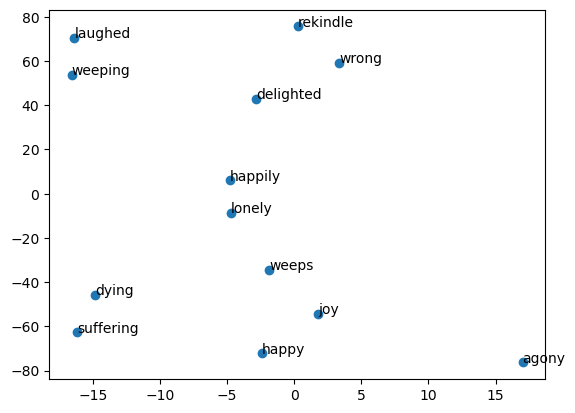

In [8]:
words_to_plot = ["happy", "happily", "delighted", "rekindle", "laughed", "joy", "wrong", "lonely", "dying", "agony", "suffering", "weeps", "weeping"]

# Adding matrix W to C
for index, row in enumerate(matrix_saved[:vocabulary_count]):
    row += matrix_saved[index + vocabulary_count]

selected_rows = []
for word in words_to_plot:
    selected_rows.append(matrix_saved[combined_tokens.index(word)])

tsne = TSNE(n_components=2, perplexity=5)
embedded_vectors = tsne.fit_transform(np.array(selected_rows))

plt.scatter(embedded_vectors[:, 0], embedded_vectors[:, 1])

for i, word in enumerate(words_to_plot):
    plt.text(embedded_vectors[i, 0], embedded_vectors[i, 1], word)

plt.show()